## IRIS Task

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

## Helper functions for handling data

In [227]:
name_classes = np.array(["Setosa", "Versicolor", "Virginica"])
name_features = np.array(["Sepal length", "Sepal width", "Petal length", "Petal width"])

def load_data() -> np.array:
    """Load the data from all three classes into on 3D numpy array"""
    class_1_data = np.loadtxt('iris_data/class_1', dtype=np.float32, delimiter=',')  # Setosa
    class_2_data = np.loadtxt('iris_data/class_2', dtype=np.float32, delimiter=',')  # Versicolor
    class_3_data = np.loadtxt('iris_data/class_3', dtype=np.float32, delimiter=',')  # Virginica
    data = np.stack((class_1_data, class_2_data, class_3_data))
    return data

def split_data(data, train_size) -> tuple[np.array, np.array]:
    """Split the data from each class into two chucnks, the first with train_size
    data points. Combine the first chuncks from each class togheter, same for second chunk"""
    splitted_data = np.split(data, [train_size], axis=1)   # Split data from each class
    train_data = np.concatenate(splitted_data[0], axis=0)  # Combine training chunck from each class
    test_data = np.concatenate(splitted_data[1], axis=0)   # Combine test chunck from each class
    return (train_data, test_data)

def extend_data(data) -> np.array:
    """To simplify calculations we extend each sample with a 1 to add the
    constant term w0"""
    return np.concatenate((data, np.ones((data.shape[0], 1))), axis=1)

def generate_labels(train_size) -> tuple[np.array, np.array]:
    """Generate labels for both the training set and test set"""
    T_train = np.concatenate((
        np.tile([1,0,0], (train_size, 1)),
        np.tile([0,1,0], (train_size, 1)),
        np.tile([0,0,1], (train_size, 1)))
    )

    T_test = np.concatenate((
        np.tile([1,0,0], (50 - train_size, 1)),
        np.tile([0,1,0], (50 - train_size, 1)),
        np.tile([0,0,1], (50 - train_size, 1)))
    )

    return T_train, T_test

## Helper functions for training of linear classifier

In [228]:
def g(x, W):
    """Produce a value 0-1 for a given feature vector. Equation 20 on vector form classification compendium"""
    zk = np.matmul(W, x)
    gk = 1 / (1 + np.exp(-zk))
    return gk

def MSE(X, T, W):
    """Calculate the MSE, taken from equation 19 in classification compendium"""
    mseSum = 0
    for i in range(np.size(X, 0)):
        xk = X[i,:]
        tk = T[i,:]
        gk = g(xk, W)
        
        mseSum += (1/2)* np.linalg.norm((gk - tk), ord=2)
    
    return mseSum

def grad_MSE(X, T, W):
    """Gradient of MSE, taken from equation 22"""
    gradMSESum = np.zeros(W.shape)
    
    for i in range(np.size(X, 0)):
        xk = X[i,:]
        tk = T[i,:]
        gk = g(xk, W)
        
        a = np.multiply((gk - tk), gk)
        b = np.multiply(a, np.ones(3).T - gk)

        gradMSESum += np.outer(b, xk)

    return gradMSESum

def gradient_descent(alpha, X, T, W, tolerance):
    """Perform gradient descent until the gradient is quite small"""
    iterations = 0
    # while np.linalg.norm(grad_MSE(X, T, W), ord='fro') > tolerance and iterations < 1e3:
    while iterations < 2e3:

        W = W - alpha * grad_MSE(X, T, W)
        iterations += 1
        print(f"Iteration: {iterations:06}, MSE: {MSE(X, T, W):.2f}, |∇MSE|: {np.linalg.norm(grad_MSE(X, T, W), ord='fro'):.4f}")

    return (iterations, W)

## Line search algos

Step lenght determined by algorithm 3.1 in Numerical Optimization by N&W, Method of training is steepest descent

In [229]:
# Backtracking linesearch algorithm 3.1 (Not used)

alpha0 = 1
rho = 0.95
c = 10e-3

def backtrackingLineSearch(rho, c, Wk, pk, X, T):
    alpha = alpha0
    while MSE(X, T, (Wk + alpha*pk)) > MSE(X, T, Wk) + c * alpha * np.linalg.norm(np.matmul(pk.T, pk), ord='fro'):
        alpha = alpha * rho
    
    return alpha
    

## Helper functions for verification of model

In [230]:

def generate_conf_matrix(X, T, W):
    """Generate a confusion matrix for extended data X with labels T when 
    using a linear model with extend matrix W"""
    # 0-axis: true class
    # 1-axis: predicted class
    conf_matrix = np.zeros((3,3))

    for i in range(np.size(X, 0)):
        x = X[i, :]
        t = T[i, :]
        
        true_class = np.argmax(t)
        predicted_class = np.argmax(g(x, W))
        conf_matrix[true_class][predicted_class] += 1
    
    return conf_matrix


def genarate_conf_matrix_figure(conf_matrix, title):
    """Create a plt.Figure representation of the confusion matrix"""
    confusion_fig = plt.figure(figsize = (10,7))
    confusion_fig = sn.heatmap(conf_matrix, annot=True)
    
    error_rate = (np.sum(conf_matrix) - np.trace(conf_matrix)) / np.sum(conf_matrix)
    confusion_fig.set_title(f"{title}. Error rate: {error_rate*100:.1f}%")


    confusion_fig.set_ylabel("True class")
    confusion_fig.set_xlabel("Predicted class")

    confusion_fig.set_xticklabels(name_classes)
    confusion_fig.set_yticklabels(name_classes)
    return confusion_fig

### Use the first 30 samples for training and the last  20 samples for testing

In [231]:
# Task 1.1a, 1.1b

train_size = 30

X_train_raw, X_test_raw = split_data(load_data(), train_size)
print(f"Shape of raw train data {X_train_raw.shape}")
print(f"Shape of raw test data {X_test_raw.shape}")

X_train, X_test = extend_data(X_train_raw), extend_data(X_test_raw)
print(f"Shape of extended train data {X_train.shape}")
print(f"Shape of extended test data {X_test.shape}")

# Use a seed to get a reproducable result
np.random.seed(38)

# W is 3x4 and w0 is 3x1, together we get w W 3x5 ([W w0])
# Initialize a W matrix
W = np.random.uniform(-1, 1, (3,5))

T_train, T_test = generate_labels(train_size)
iterations, W = gradient_descent(alpha=0.01, X=X_train, T=T_train, W=W,tolerance=0.02)
print(f"RESULT - iterations: {iterations:06}, mse: {MSE(X_train, T_train, W):06.2f}")

Shape of raw train data (90, 4)
Shape of raw test data (60, 4)
Shape of extended train data (90, 5)
Shape of extended test data (60, 5)
Iteration: 000001, MSE: 41.81, |∇MSE|: 19.2506
Iteration: 000002, MSE: 41.75, |∇MSE|: 19.8648
Iteration: 000003, MSE: 43.84, |∇MSE|: 42.0823
Iteration: 000004, MSE: 42.52, |∇MSE|: 28.2409
Iteration: 000005, MSE: 42.70, |∇MSE|: 36.4775
Iteration: 000006, MSE: 42.20, |∇MSE|: 42.0007
Iteration: 000007, MSE: 42.15, |∇MSE|: 28.6154
Iteration: 000008, MSE: 41.70, |∇MSE|: 27.1774
Iteration: 000009, MSE: 39.85, |∇MSE|: 21.0562
Iteration: 000010, MSE: 40.11, |∇MSE|: 16.9863
Iteration: 000011, MSE: 39.56, |∇MSE|: 40.7083
Iteration: 000012, MSE: 34.48, |∇MSE|: 36.8544
Iteration: 000013, MSE: 35.89, |∇MSE|: 34.7012
Iteration: 000014, MSE: 32.87, |∇MSE|: 36.9056
Iteration: 000015, MSE: 34.64, |∇MSE|: 41.7160
Iteration: 000016, MSE: 32.10, |∇MSE|: 46.8574
Iteration: 000017, MSE: 34.81, |∇MSE|: 45.9414
Iteration: 000018, MSE: 29.80, |∇MSE|: 49.3269
Iteration: 000019,

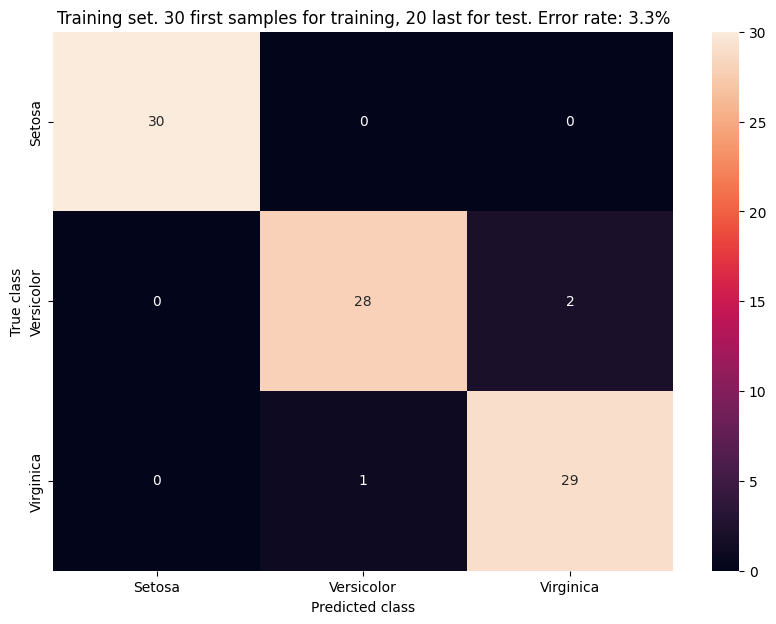

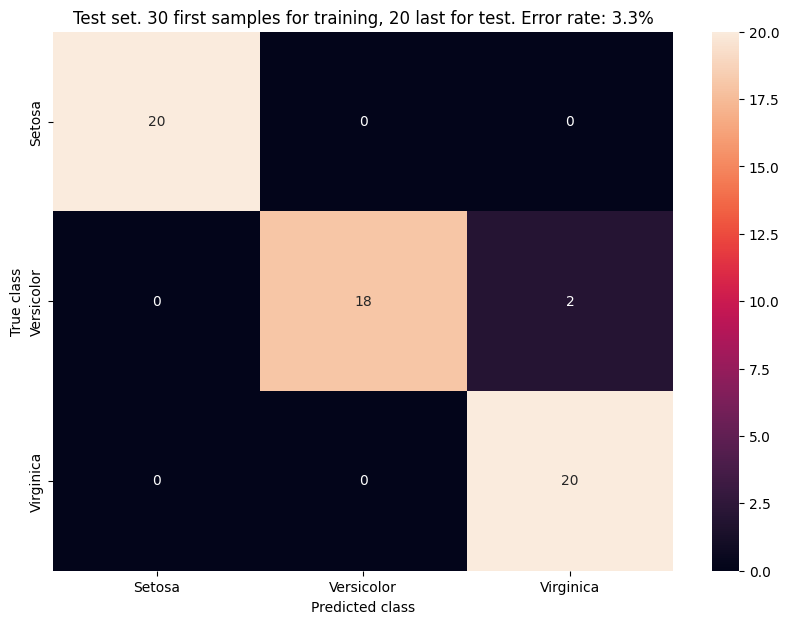

In [232]:
# Task 1.1c

conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
fig_train = genarate_conf_matrix_figure(conf_matrix_train, "Training set. 30 first samples for training, 20 last for test")

conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
fig_test = genarate_conf_matrix_figure(conf_matrix_test, "Test set. 30 first samples for training, 20 last for test")

plt.show()

### Use the last 30 samples for training and the first 20 samples for testing

In [233]:
# Task 1.1d, training part

train_size = 30

# Flip the data in each class
reversed_data = np.flip(load_data(), axis=1)

X_train_raw, X_test_raw = split_data(reversed_data, train_size)
print(f"Shape of raw train data {X_train_raw.shape}")
print(f"Shape of raw test data {X_test_raw.shape}")

X_train, X_test = extend_data(X_train_raw), extend_data(X_test_raw)
print(f"Shape of extended train data {X_train.shape}")
print(f"Shape of extended test data {X_test.shape}")

# Use a seed to get a reproducable result
np.random.seed(38)

# W is 3x4 and w0 is 3x1, together we get w W 3x5 ([W w0])
# Initialize a W matrix
W = np.random.uniform(-1, 1, (3,5))

T_train, T_test = generate_labels(train_size)
iterations, W = gradient_descent(alpha=0.01, X=X_train, T=T_train, W=W,tolerance=0.02)
print(f"RESULT - iterations: {iterations:06}, mse: {MSE(X_train, T_train, W):06.2f}")

Shape of raw train data (90, 4)
Shape of raw test data (60, 4)
Shape of extended train data (90, 5)
Shape of extended test data (60, 5)
Iteration: 000001, MSE: 41.95, |∇MSE|: 18.0234
Iteration: 000002, MSE: 41.85, |∇MSE|: 18.2790
Iteration: 000003, MSE: 43.85, |∇MSE|: 39.0583
Iteration: 000004, MSE: 42.38, |∇MSE|: 30.5745
Iteration: 000005, MSE: 42.37, |∇MSE|: 23.7953
Iteration: 000006, MSE: 40.38, |∇MSE|: 19.7928
Iteration: 000007, MSE: 41.11, |∇MSE|: 12.2108
Iteration: 000008, MSE: 40.40, |∇MSE|: 22.3341
Iteration: 000009, MSE: 42.28, |∇MSE|: 40.7818
Iteration: 000010, MSE: 42.67, |∇MSE|: 45.8008
Iteration: 000011, MSE: 41.59, |∇MSE|: 44.9466
Iteration: 000012, MSE: 34.18, |∇MSE|: 32.1012
Iteration: 000013, MSE: 35.54, |∇MSE|: 35.8598
Iteration: 000014, MSE: 32.89, |∇MSE|: 37.9334
Iteration: 000015, MSE: 34.03, |∇MSE|: 39.5921
Iteration: 000016, MSE: 30.61, |∇MSE|: 44.5894
Iteration: 000017, MSE: 33.63, |∇MSE|: 48.2454
Iteration: 000018, MSE: 28.82, |∇MSE|: 44.8106
Iteration: 000019,

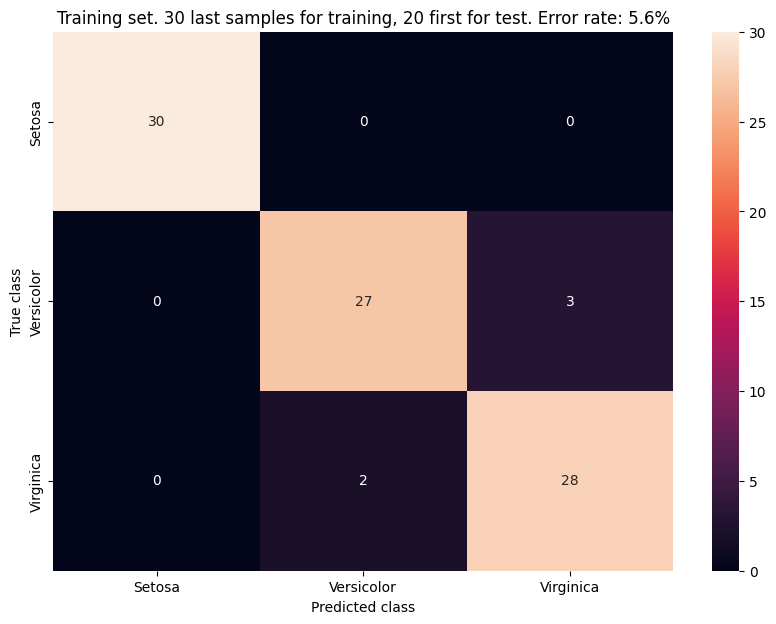

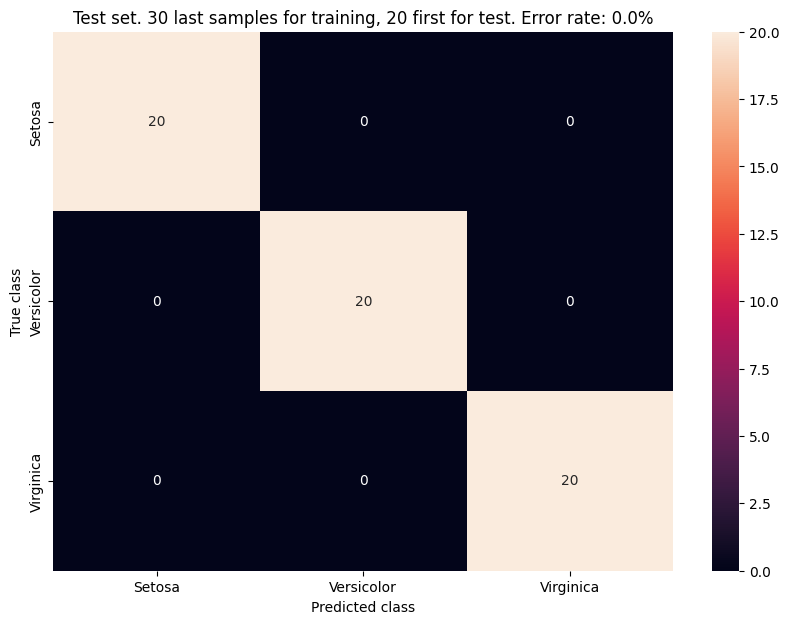

In [234]:
# Task 1.1d, data illustration

conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
fig_train = genarate_conf_matrix_figure(conf_matrix_train, "Training set. 30 last samples for training, 20 first for test")

conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
fig_test = genarate_conf_matrix_figure(conf_matrix_test, "Test set. 30 last samples for training, 20 first for test")

plt.show()

## Produce historgrams for each feature and class

Measure of overlap in each feature: [('Sepal length', 932), ('Sepal width', 1131), ('Petal length', 886), ('Petal width', 688)]
Feature with largest overlap is: Sepal width


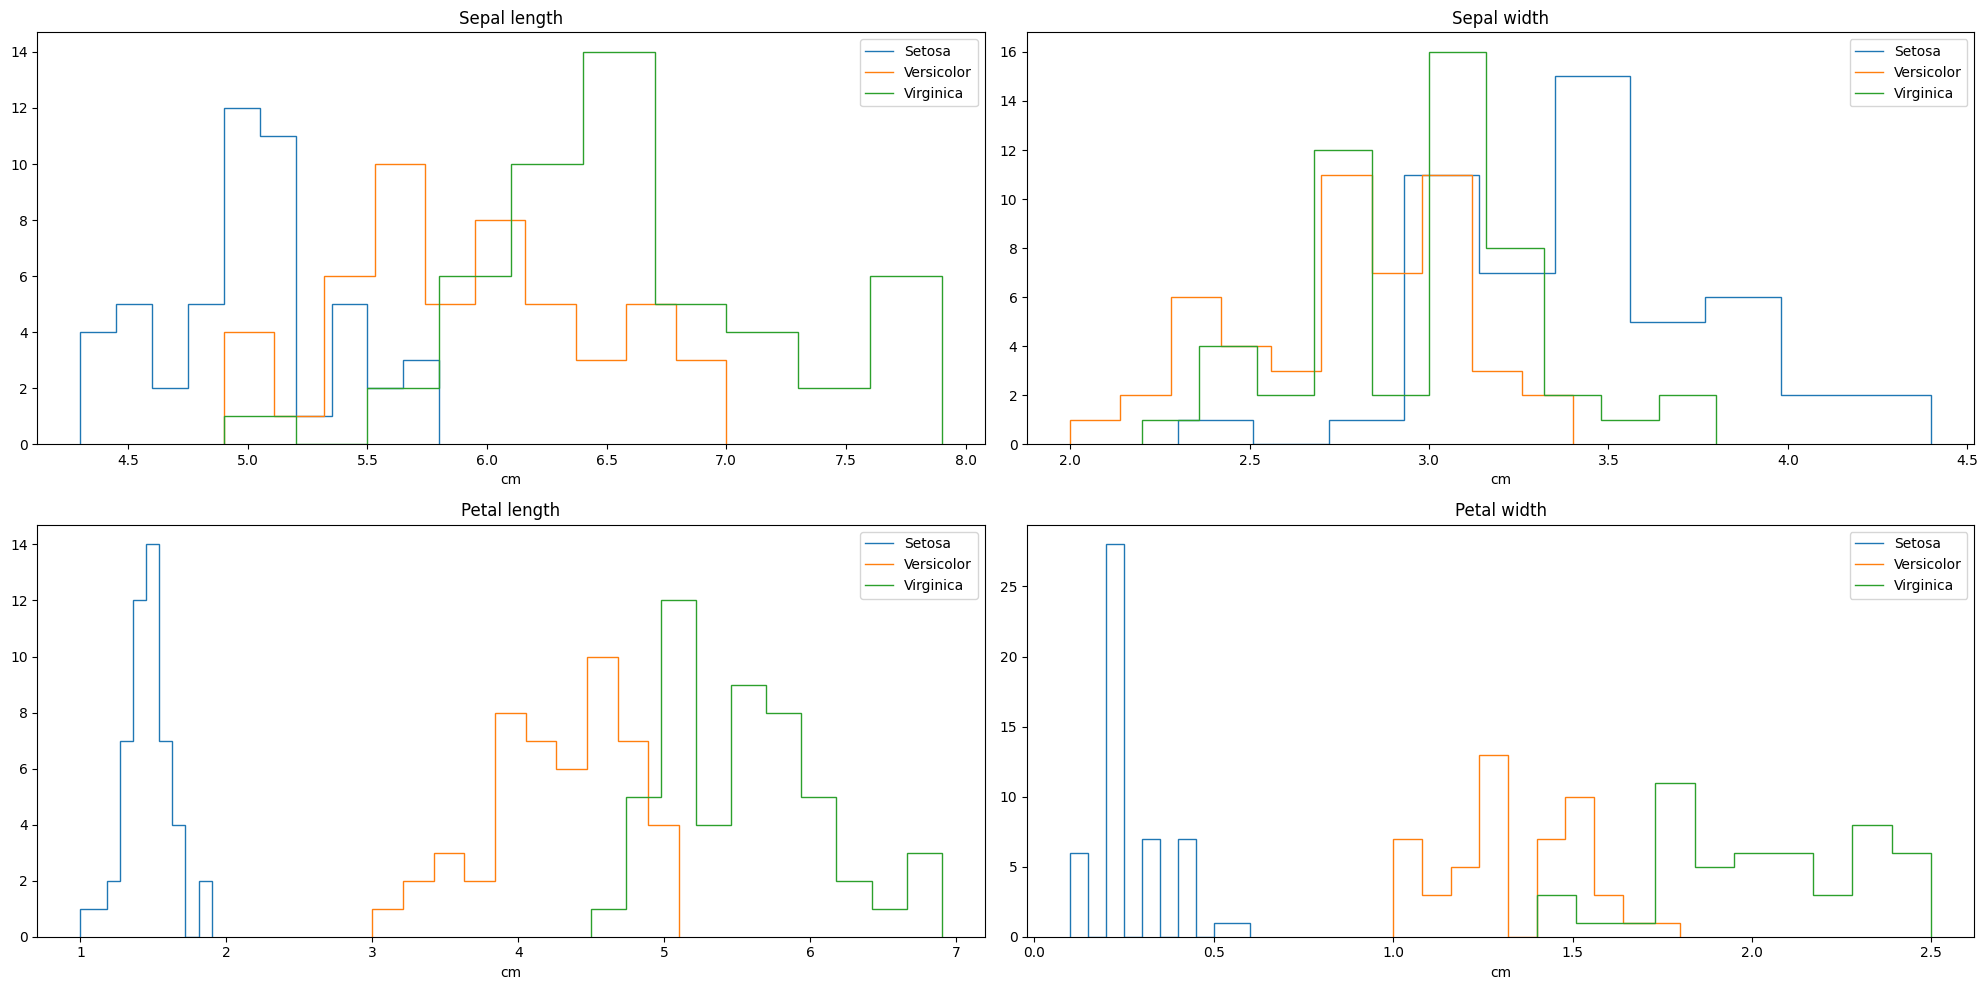

In [235]:
# Task 1.2a, data visualization
data = load_data()

hists = [[], [], []]

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

for feat in range(4):
    for cls in range(3):
        
        feature = data[cls][:, feat]
        counts, bins = np.histogram(feature, bins=10)
        hists[cls].append({"counts": counts, "bins": bins})

        axs[feat].stairs(counts, bins, label=name_classes[cls], )

    axs[feat].legend()
    axs[feat].set_title(name_features[feat])
    axs[feat].set_xlabel("cm")

fig.tight_layout()

# Calculate correlation between the signals at lag 0 to identify largest overlap
corr_feat = []
for feat in range(4):
    corr_0_1 = np.sum(hists[0][feat]["counts"] * hists[1][feat]["counts"])
    corr_0_2 = np.sum(hists[0][feat]["counts"] * hists[2][feat]["counts"])
    corr_1_2 = np.sum(hists[1][feat]["counts"] * hists[2][feat]["counts"])
    corr_feat.append(corr_0_1 + corr_0_2 + corr_1_2)

print(f"Measure of overlap in each feature: {list(zip(name_features, corr_feat))}")
print(f"Feature with largest overlap is: {name_features[np.argmax(corr_feat)]}")



Shape of raw train data with one less feature (90, 3)
Shape of raw test data with one less feature (60, 3)
Shape of extended train data (90, 4)
Shape of extended test data (60, 4)
Iteration: 000001, MSE: 53.62, |∇MSE|: 33.3390
Iteration: 000002, MSE: 44.95, |∇MSE|: 31.4857
Iteration: 000003, MSE: 43.91, |∇MSE|: 16.4292
Iteration: 000004, MSE: 42.44, |∇MSE|: 15.1518
Iteration: 000005, MSE: 43.73, |∇MSE|: 19.4901
Iteration: 000006, MSE: 40.54, |∇MSE|: 24.2925
Iteration: 000007, MSE: 41.64, |∇MSE|: 38.3470
Iteration: 000008, MSE: 37.50, |∇MSE|: 27.9204
Iteration: 000009, MSE: 35.74, |∇MSE|: 27.0200
Iteration: 000010, MSE: 35.55, |∇MSE|: 26.8907
Iteration: 000011, MSE: 33.78, |∇MSE|: 26.2724
Iteration: 000012, MSE: 33.25, |∇MSE|: 25.2505
Iteration: 000013, MSE: 31.85, |∇MSE|: 22.6605
Iteration: 000014, MSE: 31.13, |∇MSE|: 22.4827
Iteration: 000015, MSE: 30.47, |∇MSE|: 22.7755
Iteration: 000016, MSE: 29.33, |∇MSE|: 27.5630
Iteration: 000017, MSE: 30.17, |∇MSE|: 31.2646
Iteration: 000018, MS

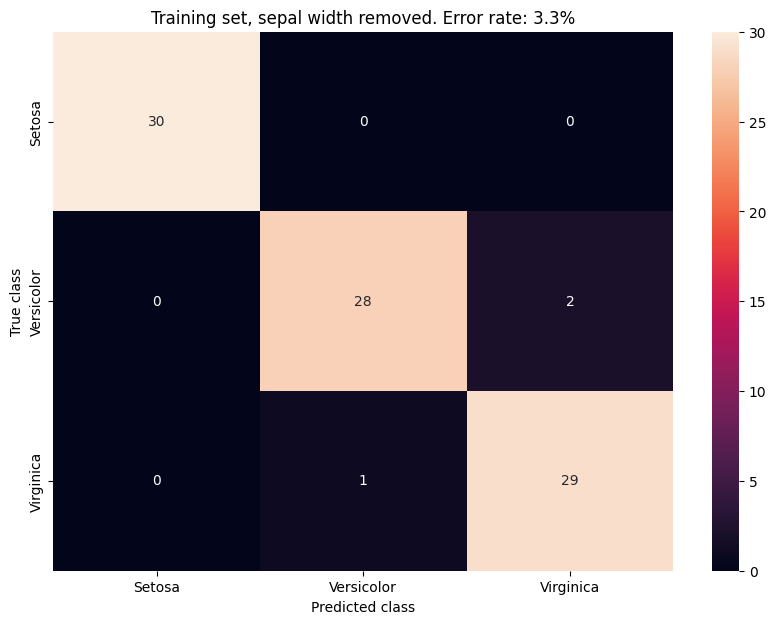

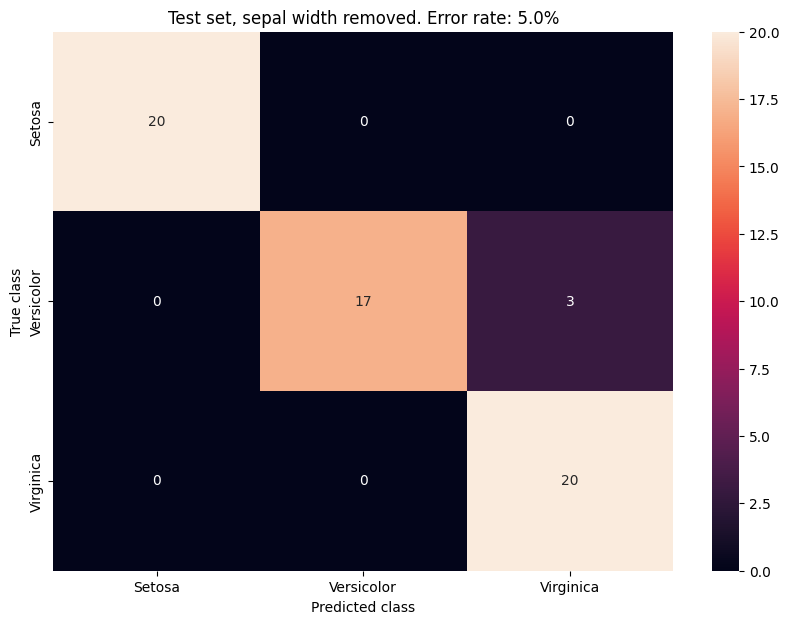

In [236]:
# Task 1.2a, remove sepal width

train_size = 30

X_train_raw, X_test_raw = split_data(load_data(), train_size)

# Remove Sepal width as a feature
X_train = np.delete(X_train_raw, obj=1, axis=1)
X_test = np.delete(X_test_raw, obj=1, axis=1)

print(f"Shape of raw train data with one less feature {X_train.shape}")
print(f"Shape of raw test data with one less feature {X_test.shape}")

X_train, X_test = extend_data(X_train), extend_data(X_test)
print(f"Shape of extended train data {X_train.shape}")
print(f"Shape of extended test data {X_test.shape}")


np.random.seed(0)
W = np.random.uniform(-1, 1, (3,4))

T_train, T_test = generate_labels(train_size)
iterations, W = gradient_descent(alpha=0.01, X=X_train, T=T_train, W=W, tolerance=5.6)
print(f"RESULT - iterations: {iterations:06}, mse: {MSE(X_train, T_train, W):06.2f}")

# Illustrate data
conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
fig_train = genarate_conf_matrix_figure(conf_matrix_train, "Training set, sepal width removed")

conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
fig_test = genarate_conf_matrix_figure(conf_matrix_test, "Test set, sepal width removed")

plt.show()

Iteration: 000001, MSE: 35.33, |∇MSE|: 5.7558
Iteration: 000002, MSE: 35.19, |∇MSE|: 5.3095
Iteration: 000003, MSE: 35.03, |∇MSE|: 5.1994
Iteration: 000004, MSE: 34.88, |∇MSE|: 5.1342
Iteration: 000005, MSE: 34.72, |∇MSE|: 5.0799
Iteration: 000006, MSE: 34.57, |∇MSE|: 5.0275
Iteration: 000007, MSE: 34.41, |∇MSE|: 4.9752
Iteration: 000008, MSE: 34.26, |∇MSE|: 4.9227
Iteration: 000009, MSE: 34.11, |∇MSE|: 4.8699
Iteration: 000010, MSE: 33.97, |∇MSE|: 4.8171
Iteration: 000011, MSE: 33.82, |∇MSE|: 4.7641
Iteration: 000012, MSE: 33.68, |∇MSE|: 4.7111
Iteration: 000013, MSE: 33.53, |∇MSE|: 4.6582
Iteration: 000014, MSE: 33.39, |∇MSE|: 4.6054
Iteration: 000015, MSE: 33.26, |∇MSE|: 4.5528
Iteration: 000016, MSE: 33.12, |∇MSE|: 4.5003
Iteration: 000017, MSE: 32.99, |∇MSE|: 4.4482
Iteration: 000018, MSE: 32.86, |∇MSE|: 4.3963
Iteration: 000019, MSE: 32.73, |∇MSE|: 4.3448
Iteration: 000020, MSE: 32.60, |∇MSE|: 4.2937
Iteration: 000021, MSE: 32.47, |∇MSE|: 4.2430
Iteration: 000022, MSE: 32.35, |∇M

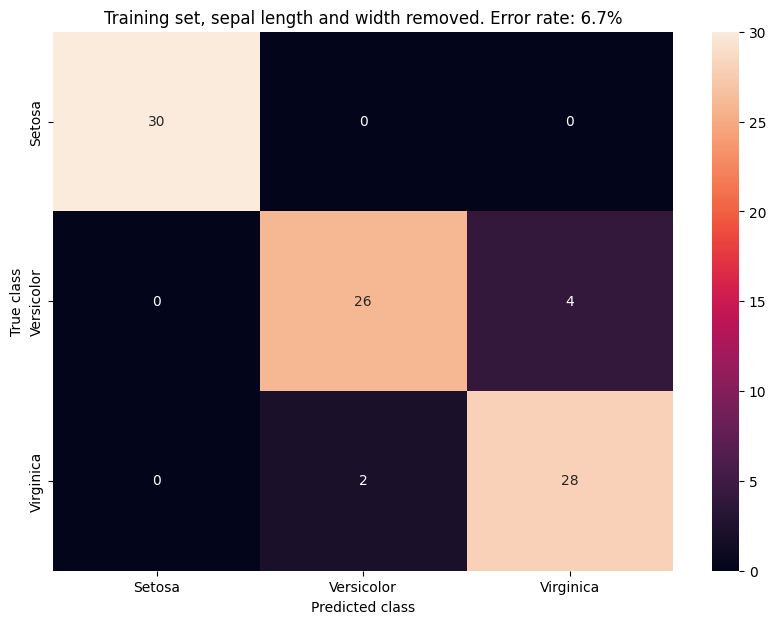

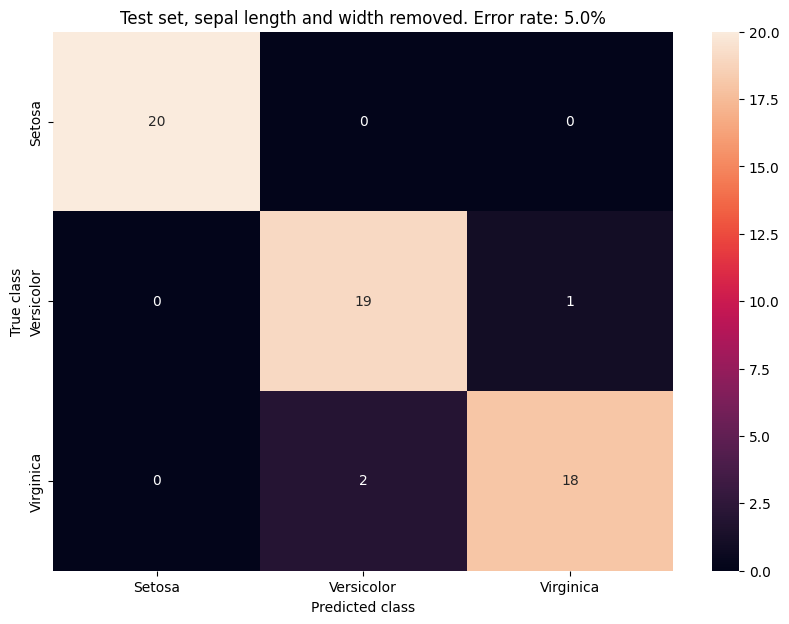

In [237]:
# Task 1.2a, remove sepal width andl length

train_size = 30

X_train_raw, X_test_raw = split_data(load_data(), train_size)

# Remove sepal length and width as a feature
X_train = np.delete(X_train_raw, obj=[0, 1], axis=1)
X_test = np.delete(X_test_raw, obj=[0, 1], axis=1)

X_train, X_test = extend_data(X_train), extend_data(X_test)


# np.random.seed(200)
# W = np.random.uniform(-1, 1, (3, X_train.shape[1]))
W = np.zeros((3, X_train.shape[1])) 



T_train, T_test = generate_labels(train_size)
iterations, W = gradient_descent(alpha=0.01, X=X_train, T=T_train, W=W, tolerance=5.6)
print(f"RESULT - iterations: {iterations:06}, mse: {MSE(X_train, T_train, W):06.2f}")

# Illustrate data
conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
fig_train = genarate_conf_matrix_figure(conf_matrix_train, "Training set, sepal length and width removed")

conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
fig_test = genarate_conf_matrix_figure(conf_matrix_test, "Test set, sepal length and width removed")

plt.show()

Iteration: 000001, MSE: 37.92, |∇MSE|: 11.8391
Iteration: 000002, MSE: 37.11, |∇MSE|: 10.0779
Iteration: 000003, MSE: 36.51, |∇MSE|: 8.7000
Iteration: 000004, MSE: 36.04, |∇MSE|: 7.6698
Iteration: 000005, MSE: 35.67, |∇MSE|: 6.9101
Iteration: 000006, MSE: 35.36, |∇MSE|: 6.3485
Iteration: 000007, MSE: 35.10, |∇MSE|: 5.9291
Iteration: 000008, MSE: 34.86, |∇MSE|: 5.6109
Iteration: 000009, MSE: 34.65, |∇MSE|: 5.3649
Iteration: 000010, MSE: 34.46, |∇MSE|: 5.1706
Iteration: 000011, MSE: 34.28, |∇MSE|: 5.0136
Iteration: 000012, MSE: 34.11, |∇MSE|: 4.8838
Iteration: 000013, MSE: 33.95, |∇MSE|: 4.7738
Iteration: 000014, MSE: 33.79, |∇MSE|: 4.6786
Iteration: 000015, MSE: 33.65, |∇MSE|: 4.5944
Iteration: 000016, MSE: 33.50, |∇MSE|: 4.5185
Iteration: 000017, MSE: 33.36, |∇MSE|: 4.4489
Iteration: 000018, MSE: 33.22, |∇MSE|: 4.3842
Iteration: 000019, MSE: 33.09, |∇MSE|: 4.3234
Iteration: 000020, MSE: 32.96, |∇MSE|: 4.2655
Iteration: 000021, MSE: 32.83, |∇MSE|: 4.2101
Iteration: 000022, MSE: 32.71, |

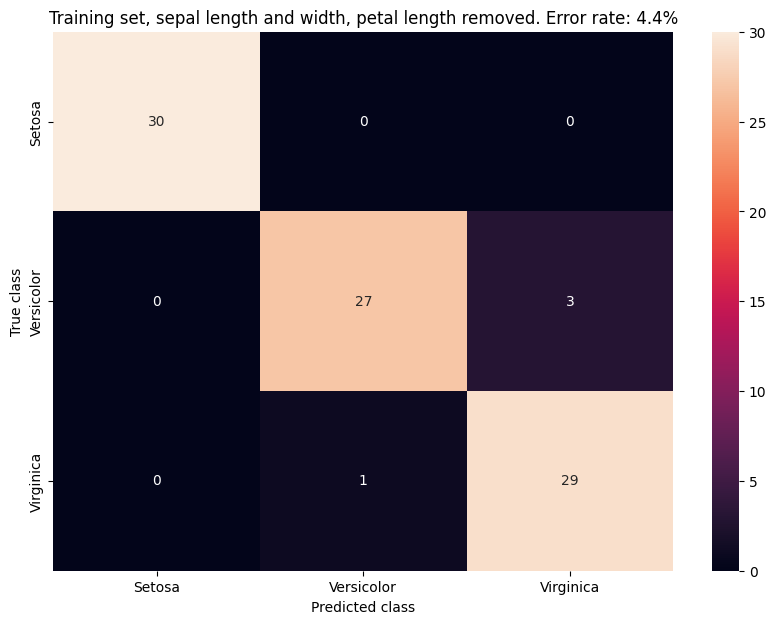

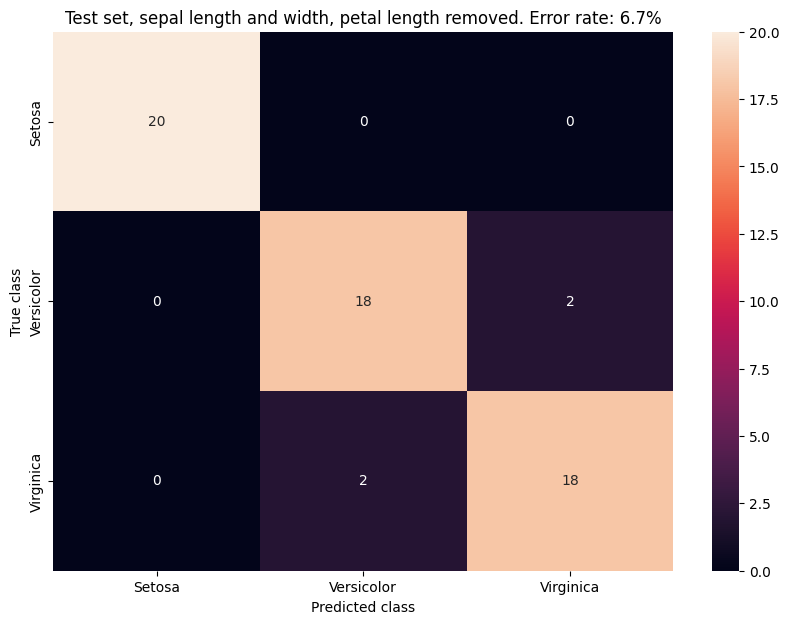

In [238]:
# Task 1.2a, remove sepal width andl length

train_size = 30

X_train_raw, X_test_raw = split_data(load_data(), train_size)

# Remove sepal length and width as a feature
X_train = np.delete(X_train_raw, obj=[0, 1, 2], axis=1)
X_test = np.delete(X_test_raw, obj=[0, 1, 2], axis=1)
X_train, X_test = extend_data(X_train), extend_data(X_test)


W = np.zeros((3, X_train.shape[1])) 


T_train, T_test = generate_labels(train_size)
iterations, W = gradient_descent(alpha=0.01, X=X_train, T=T_train, W=W, tolerance=5.6)
print(f"RESULT - iterations: {iterations:06}, mse: {MSE(X_train, T_train, W):06.2f}")

# Illustrate data
conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
fig_train = genarate_conf_matrix_figure(conf_matrix_train, "Training set, sepal length and width, petal length removed")

conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
fig_test = genarate_conf_matrix_figure(conf_matrix_test, "Test set, sepal length and width, petal length removed")

plt.show()

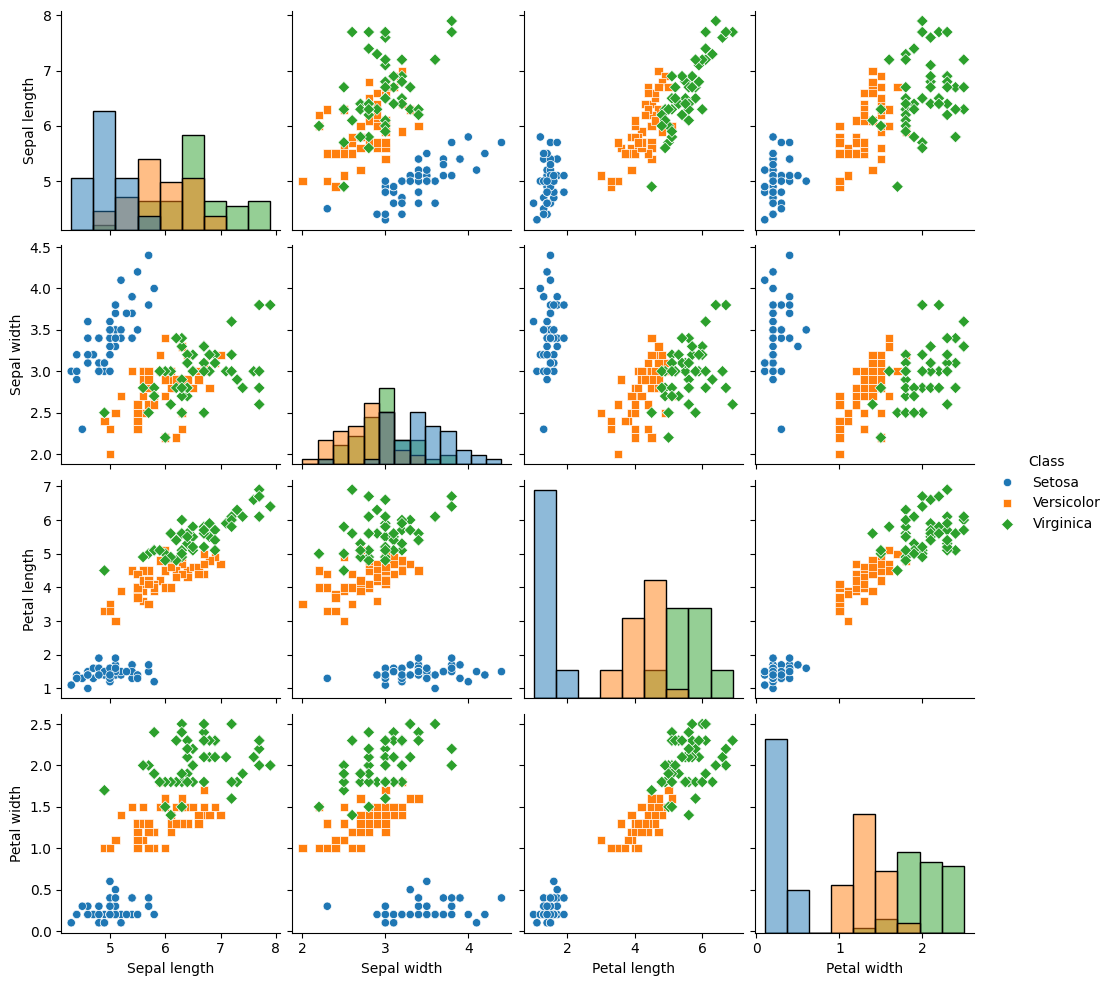

In [285]:
# Not part of the task, consider removing

import pandas as pd

data = load_data()
T, _ = generate_labels(50)
class_labels = name_classes[np.argmax(T, axis=1)]

data_with_class = np.column_stack((data.reshape((150, 4)), class_labels))

df = pd.DataFrame(data.reshape((150, 4)), columns=name_features, dtype=float)
df["Class"] = class_labels
# Pairplot with classes marked
sn.pairplot(df, hue="Class", diag_kind="hist", markers=["o", "s", "D"])

plt.show()